# Buoy localisation
We will use a Gaussian mixture model to localise the buoys.
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters.

Variational Bayesian estimation of a Gaussian mixture.

This class allows to infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution. The effective number of components can be inferred from the data

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import sys; sys.path.append('../src/')
import bt_actions
import importlib
%matplotlib inline

In [ ]:
# ground truth walls
lines = np.load('walls.npy')
points = np.vstack(lines)

In [1]:
# generate data
importlib.reload(bt_actions)
samples = bt_actions.A_ReadBuoys.generate_data(points=points, n_samples=500, sigma=1)
samples

NameError: name 'importlib' is not defined

In [ ]:
# plotting
importlib.reload(bt_actions)
fig, ax = bt_actions.A_ReadBuoys.plot(lines=lines, samples=samples)
plt.show()

In [ ]:
# clustering
importlib.reload(bt_actions)
mu, sigma, gsigma, labels, model = bt_actions.A_ReadBuoys.approximate(samples=samples, n_components=16)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu, samples=samples, lines=lines, c=labels)
plt.show()

In [6]:
# filtering means based on generalized varaiance
importlib.reload(bt_actions)
sigma_tol = 15.0
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, c=labels)
plt.show()

NameError: name 'mu' is not defined

In [7]:
# inferring lines from the data given a priori theta=116 [deg] and n_lines=4
importlib.reload(bt_actions)
sample_lines = bt_actions.A_ReadBuoys.infer_lines(points=mu[gsigma<sigma_tol], theta=116, n_lines=4, atol=1e-2, dtol=1.0)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, sample_lines=sample_lines, c=labels)
plt.show()

NameError: name 'mu' is not defined


Number of samples: 100
Number of buoys approximated: 2
Number of certain buoys: 0
Number of lines infered: 0


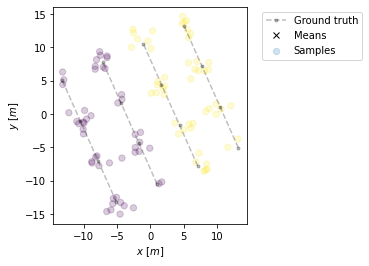


Number of samples: 100
Number of buoys approximated: 5
Number of certain buoys: 0
Number of lines infered: 0


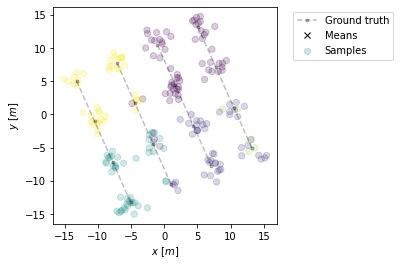


Number of samples: 100
Number of buoys approximated: 9
Number of certain buoys: 1
Number of lines infered: 0


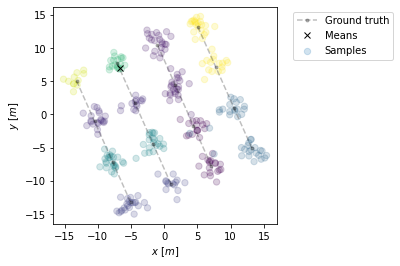


Number of samples: 100
Number of buoys approximated: 10
Number of certain buoys: 3
Number of lines infered: 1


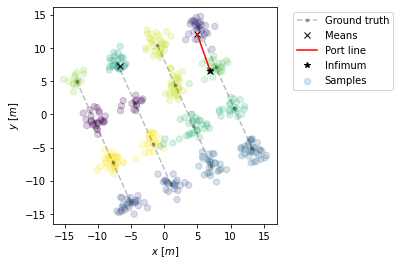


Number of samples: 100
Number of buoys approximated: 13
Number of certain buoys: 9
Number of lines infered: 3


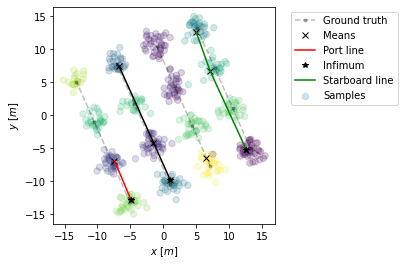


Number of samples: 100
Number of buoys approximated: 14
Number of certain buoys: 12
Number of lines infered: 4


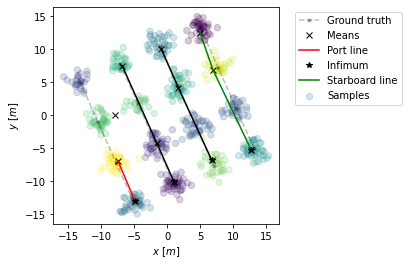


Number of samples: 100
Number of buoys approximated: 14
Number of certain buoys: 12
Number of lines infered: 4


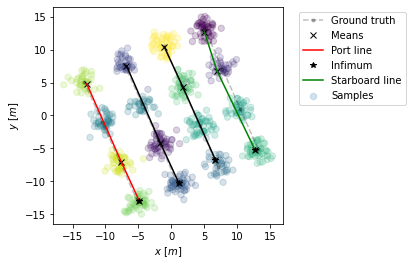


Number of samples: 100
Number of buoys approximated: 15
Number of certain buoys: 15
Number of lines infered: 4


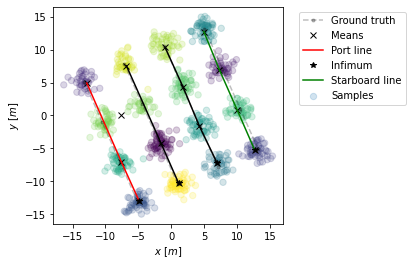


Number of samples: 100
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


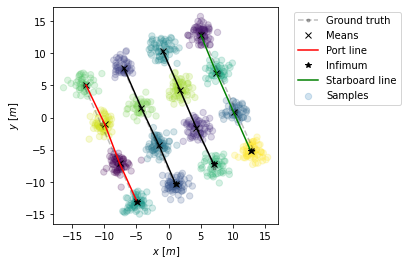


Number of samples: 100
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


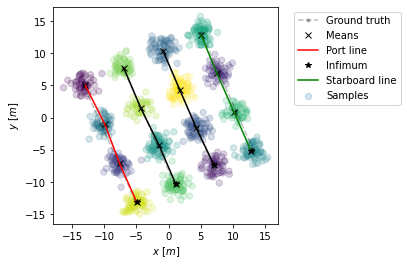

In [10]:
# let's put it all together...
importlib.reload(bt_actions)

# variance of sampling
sigma = 1.0
# number of buoys (a priori)
n_components = 16
# generalised variance tolerance
gsigma_tol = 5.0
# number of lines (a priori)
n_lines = 4
# line-angle tolerance
atol=1e-2
# line-inclusion distance tolerance
dtol=1e-2
# use trace
use_trace = True
# number of samples to taker per epoch
n_samples = 100
# number of epochs
epo = 10
# model
model = BayesianGaussianMixture(n_components=n_components, warm_start=True)

# loop through different number of samples,
# incrementally updating the Gaussian mixture model
samples = np.empty((0,3))
for _ in range(epo):

    # gather data
    sample = bt_actions.A_ReadBuoys.generate_data(
        points=points, 
        n_samples=n_samples, 
        sigma=sigma
    )
    samples = np.vstack((samples, sample))

    # localise buoys
    mu, covar, gsigma, labels, model = bt_actions.A_ReadBuoys.approximate(
        samples=samples, 
        n_components=n_components,
        use_trace=use_trace,
        model=None
    )

    # infer walls
    sample_lines = bt_actions.A_ReadBuoys.infer_lines(
        points=mu[gsigma<sigma_tol], 
        theta=116, 
        n_lines=4, 
        atol=1e-2, 
        dtol=1.0
    )
    
    # information
    print('')
    print('Number of samples: {}'.format(n_samples))
    print('Number of buoys approximated: {}'.format(mu.shape[0]))
    print('Number of certain buoys: {}'.format(mu[gsigma<sigma_tol].shape[0]))
    print('Number of lines infered: {}'.format(len(sample_lines)))

    # plot it
    fig, ax = bt_actions.A_ReadBuoys.plot(
        lines=lines,
        samples=samples,
        means=mu[gsigma<sigma_tol], 
        sample_lines=sample_lines, 
        c=labels
    )
    # fig.savefig('img/buoys_{}.png'.format(n_samples), dpi=1000, bbox_inches='tight')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

# Perimeter localisation plan

Alrighty, seems like the buoy localisation stuff above checks out.
Time to devise a path to follow to localise the buoys.
We will assume that we know the approximate location of
the centroid, as well as the orientation (as before).
We will also take a safe starting distance as an argument.

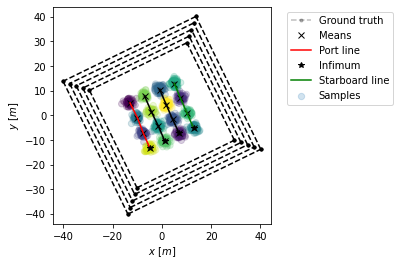

In [11]:
# plot it
from itertools import cycle
importlib.reload(bt_actions)
line = bt_actions.A_SetBuoyLocalisationPlan.perimeter_line(
    centroid=points.mean(axis=0),
    angle=116,
    distance=20.0,
    face=0,
    side=0
)
fig, ax = bt_actions.A_ReadBuoys.plot(
    lines=lines,
    samples=samples,
    means=mu[gsigma<sigma_tol], 
    sample_lines=sample_lines, 
    c=labels
)

dist = 30
centroid = points.mean(axis=0)
i = 0
for j in cycle([0,1,2,3]):
    line = bt_actions.A_SetBuoyLocalisationPlan.perimeter_line(
        centroid=centroid,
        angle=116,
        distance=dist,
        face=j,
        side=0
    )
    ax.plot(line[:,0], line[:,1], 'k.--')
    if j == 3:
        dist -= 2
        i += 1
    if i == 5:
        break
    
# fig.savefig('img/buoys_{}.png'.format(n_samples), dpi=1000, bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [12]:
importlib.reload(bt_actions)

# random pose
pose = np.random.uniform(low=0, high=2*np.pi)
pose = np.array([np.cos(pose), np.sin(pose)])
r = np.random.uniform(low=50, high=50)
pose = r*pose 

In [18]:
importlib.reload(bt_actions)

# compute path
direction = [4,-4]
path = bt_actions.A_SetBuoyLocalisationPlan.perimeter_plan(
    point=pose,
    origin=centroid,
    angle=116,
    distances=[35, 30, 25, 20],
    direction=direction
)
# path
# pose

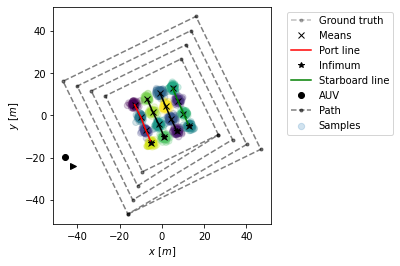

In [19]:
fig, ax = bt_actions.A_ReadBuoys.plot(
    lines=lines,
    samples=samples,
    means=mu[gsigma<sigma_tol], 
    sample_lines=sample_lines, 
    c=labels,
    ref_point=pose,
    path=path
)
# ax.plot(path[0,0], path[0,1], 'ks')
# ax.plot(path[1,0], path[1,1], 'k^')
# ax.plot(path[:,0], path[:,1])
vec = pose + direction
ax.plot(vec[0], vec[1], 'k>')
plt.show()

# Survéy execution plan

In [174]:
importlib.reload(bt_actions)

# compute path
direction = [4,-4]
path = bt_actions.A_SetBuoyLocalisationPlan.perimeter_plan(
    point=pose,
    origin=centroid,
    angle=116,
    distances=[r],
    direction=direction
)

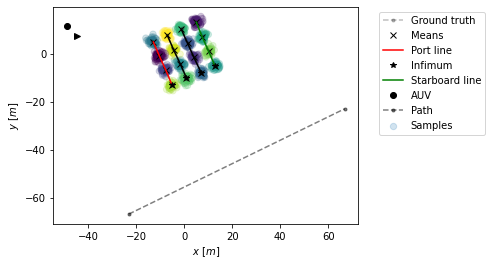

In [176]:
fig, ax = bt_actions.A_ReadBuoys.plot(
    lines=lines,
    samples=samples,
    means=mu[gsigma<sigma_tol], 
    sample_lines=sample_lines, 
    c=labels,
    ref_point=pose,
    path=path[:2]
)
# ax.plot(path[0,0], path[0,1], 'ks')
# ax.plot(path[1,0], path[1,1], 'k^')
# ax.plot(path[:,0], path[:,1])
vec = pose + direction
ax.plot(vec[0], vec[1], 'k>')
plt.show()